In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)

plt.style.use("default")
sns.set()


In [2]:
# Detect project root
CWD = Path().resolve()
if CWD.name == "notebooks":
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

print("Current working dir:", CWD)
print("Assumed project root:", PROJECT_ROOT)

PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models" / "classification"

data_path = PROCESSED_DATA / "classification_data.npz"
print("Loading data from:", data_path)

if not data_path.exists():
    raise FileNotFoundError(f"❌ classification_data.npz not found at {data_path}. Run 02_preprocessing_cnn first.")

data = np.load(data_path)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("❌ One of the splits is empty! Check preprocessing notebook/data.")

num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]
print("Number of classes:", num_classes)
print("Input shape:", input_shape)

# Class mapping (same as before)
label_map = {0: "bird", 1: "drone"}
inv_label_map = {v: k for k, v in label_map.items()}


Current working dir: F:\Aerial_Object_Classification_Detection\notebooks
Assumed project root: F:\Aerial_Object_Classification_Detection
Loading data from: F:\Aerial_Object_Classification_Detection\data\processed\classification_data.npz
Shapes:
X_train: (2662, 224, 224, 3) y_train: (2662,)
X_val:   (442, 224, 224, 3) y_val:   (442,)
X_test:  (215, 224, 224, 3) y_test:  (215,)
Number of classes: 2
Input shape: (224, 224, 3)


In [3]:
# One-hot encoding (if needed)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

def scale_for_backbone(x):
    return (x * 2.0) - 1.0  # 0–1 -> -1–1

X_test_tf = scale_for_backbone(X_test)

print("Scaled test min/max:", X_test_tf.min(), X_test_tf.max())


Scaled test min/max: -1.0 1.0


In [4]:
def load_model_if_exists(filename):
    model_path = MODELS_DIR / filename
    if model_path.exists():
        print(f"✅ Found model: {model_path.name}, loading...")
        model = load_model(model_path)
        return model, model_path
    else:
        print(f"⚠️ Model file not found: {model_path}")
        return None, model_path

models_dict = {}

# Custom CNN
model, path = load_model_if_exists("custom_cnn_best.h5")
if model is not None:
    models_dict["Custom_CNN"] = model

# Transfer Learning models
model, path = load_model_if_exists("transfer_mobilenetv2_best.h5")
if model is not None:
    models_dict["MobileNetV2"] = model

model, path = load_model_if_exists("transfer_resnet50_best.h5")
if model is not None:
    models_dict["ResNet50"] = model

model, path = load_model_if_exists("transfer_efficientnetb0_best.h5")
if model is not None:
    models_dict["EfficientNetB0"] = model

print("\nModels that will be evaluated:", list(models_dict.keys()))

if len(models_dict) == 0:
    raise RuntimeError("❌ No models found in models/classification. Train and save models first.")


⚠️ Model file not found: F:\Aerial_Object_Classification_Detection\models\classification\custom_cnn_best.h5
✅ Found model: transfer_mobilenetv2_best.h5, loading...


✅ Found model: transfer_resnet50_best.h5, loading...


✅ Found model: transfer_efficientnetb0_best.h5, loading...



Models that will be evaluated: ['MobileNetV2', 'ResNet50', 'EfficientNetB0']


In [5]:
def get_predictions(model, X, num_classes):
    """
    Returns:
      y_prob: predicted probability for class 1 (if binary) or max-prob for argmax (if multi-class)
      y_pred: predicted class indices
    """
    probs = model.predict(X, verbose=0)
    
    # If output is shape (N,) or (N,1) → binary sigmoid style
    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.reshape(-1)
        y_prob = probs
        y_pred = (probs >= 0.5).astype(int)
    else:
        # softmax; take argmax
        y_pred = np.argmax(probs, axis=1)
        if num_classes == 2:
            # probability of class "1" (drone)
            y_prob = probs[:, 1]
        else:
            # multi-class; we can use max prob for generic ROC, etc.
            y_prob = np.max(probs, axis=1)
    
    return y_prob, y_pred


In [6]:
metrics_records = []
conf_matrices = {}   # to store confusion matrices for later plotting
roc_curves = {}      # to store fpr, tpr, auc for each model

for name, model in models_dict.items():
    print(f"\n================ Evaluating: {name} ================")
    
    # Use scaled test data (what transfer models expect).
    # Custom CNN was trained on [0,1], but evaluating with [-1,1] won't crash.
    # If you want, you can add a separate branch to use X_test for Custom_CNN.
    X_eval = X_test_tf
    
    y_prob, y_pred = get_predictions(model, X_eval, num_classes=num_classes)
    
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm
    
    print("Accuracy :", acc)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1-score :", f1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["bird", "drone"], zero_division=0))
    
    # ROC AUC for binary
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc)
    
    metrics_records.append({
        "model": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    })

metrics_df = pd.DataFrame(metrics_records)
metrics_df



================ Evaluating: MobileNetV2 ================
Accuracy : 0.9813953488372092
Precision: 0.96875
Recall   : 0.9893617021276596
F1-score : 0.9789473684210527

Classification Report:
              precision    recall  f1-score   support

        bird       0.99      0.98      0.98       121
       drone       0.97      0.99      0.98        94

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215


================ Evaluating: ResNet50 ================
Accuracy : 0.7674418604651163
Precision: 0.7894736842105263
Recall   : 0.6382978723404256
F1-score : 0.7058823529411765

Classification Report:
              precision    recall  f1-score   support

        bird       0.76      0.87      0.81       121
       drone       0.79      0.64      0.71        94

    accuracy                           0.77       215
   macro avg       0.77      0.75      0.76       215
weighted 

Accuracy : 0.772093023255814
Precision: 0.8571428571428571
Recall   : 0.574468085106383
F1-score : 0.6878980891719745

Classification Report:
              precision    recall  f1-score   support

        bird       0.74      0.93      0.82       121
       drone       0.86      0.57      0.69        94

    accuracy                           0.77       215
   macro avg       0.80      0.75      0.75       215
weighted avg       0.79      0.77      0.76       215



,model,accuracy,precision,recall,f1_score,roc_auc
0,MobileNetV2,0.981395,0.968750,0.989362,0.978947,0.995604
1,ResNet50,0.767442,0.789474,0.638298,0.705882,0.839634
2,EfficientNetB0,0.772093,0.857143,0.574468,0.687898,0.815456


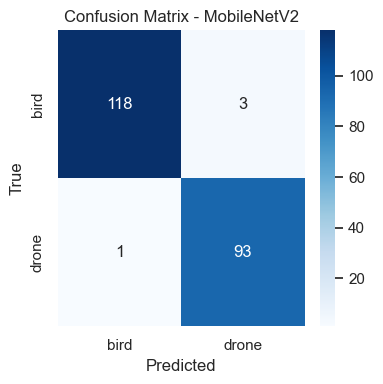

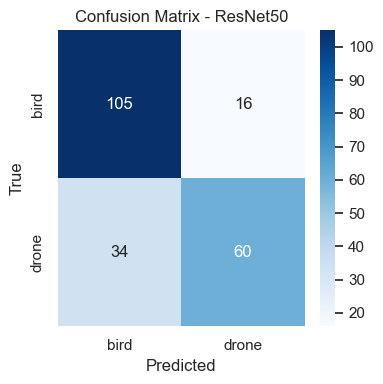

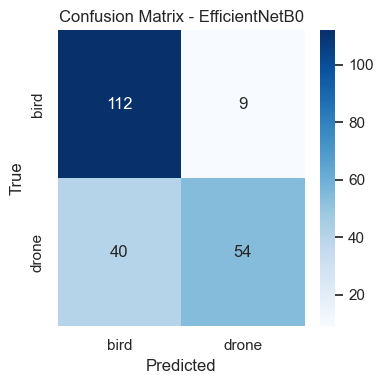

In [7]:
def plot_confusion_matrix(cm, model_name, class_names=("bird", "drone")):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

for name, cm in conf_matrices.items():
    plot_confusion_matrix(cm, name)


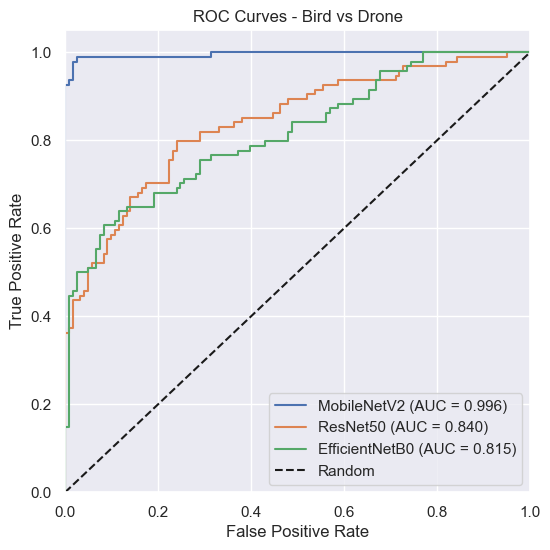

In [8]:
plt.figure(figsize=(6,6))

for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Bird vs Drone")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


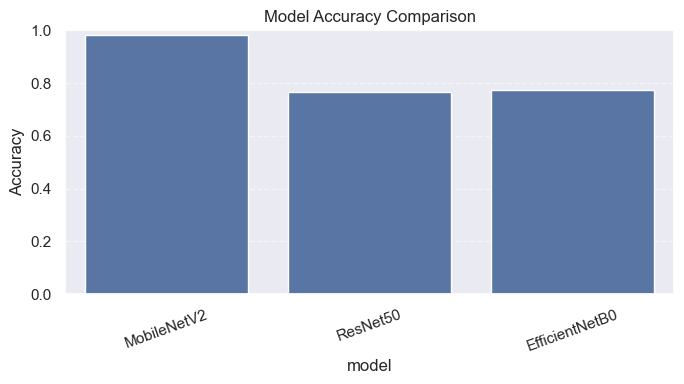

In [9]:
if not metrics_df.empty:
    plt.figure(figsize=(7,4))
    sns.barplot(data=metrics_df, x="model", y="accuracy")
    plt.ylim(0, 1.0)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No metrics to plot.")
